In [1]:
!unzip dogs.zip

Archive:  dogs.zip
   creating: dogs/
   creating: dogs/Training/
   creating: dogs/Training/n02093256-Staffordshire_bullterrier/
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_10078.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_11023.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_1132.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_11569.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_11732.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_11806.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_11820.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_1183.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_11836.jpg  
  inflating: dogs/Training/n02093256-Staffordshire_bullterrier/n02093256_12174.jpg  
  inflating: dogs/Trai

In [2]:
%reset -f
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import get_label_from_image_path, load_image_array, check_str, train_generator, valid_generator, resize_image, get_labelencoder_mapping

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Setting the directory path for the dataset 

In [3]:
datadir = Path("./dogs/")

### Defining a list of all training data paths and their labels

In [4]:
train_images = pd.Series(Path(os.path.join(datadir, 'Training')).rglob('*.jpg'))
train_labels = pd.Series(map(get_label_from_image_path, train_images)) 

test_images = pd.Series(Path(os.path.join(datadir, 'Test')).rglob('*.jpg'))
test_labels = pd.Series(map(get_label_from_image_path, test_images)) 

nb_classes = train_labels.unique().shape[0]

##### Checking value counts for each class

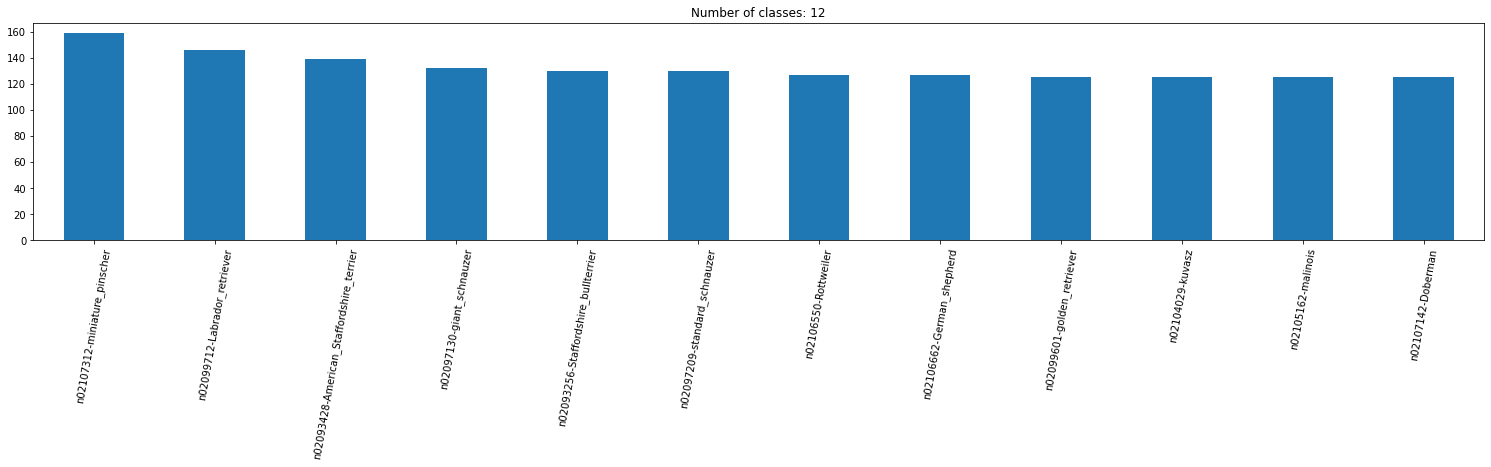

In [5]:
train_labels.value_counts().plot(kind='bar', figsize=(26,4), rot=80);
plt.title(f"Number of classes: {nb_classes}");

### Grab 25 items randomly and plot them

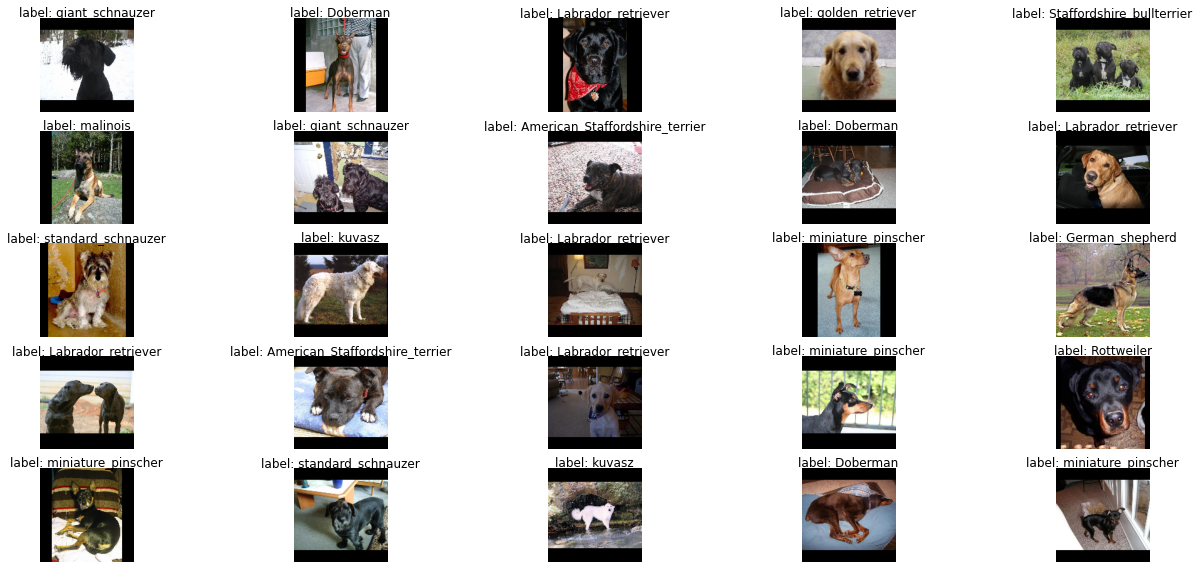

In [8]:
k = 25 
random_idx = np.random.randint(0 , len(train_images), k)

plt.figure(figsize=(22,10))
for i, rdm in enumerate(list(random_idx)):
    # loading the image
    img = load_image_array(str(train_images[rdm]))
    # plotting it in a grid 5x5
    plt.subplot(5,5,i+1)
    img = resize_image(img,size=(150,150))
    plt.imshow(img)
    plt.title(f"label: {train_labels[rdm].split('-')[-1]}", y=.95)
    plt.axis('off')
plt.show()

## Splitting the data into training / validation since we already have "Test" data in a separate folder

In [9]:
from sklearn.preprocessing import LabelEncoder

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.15, random_state=42)

# Using strings for the paths for convenience
X_train = [str(i) for i in X_train]
X_val = [str(i) for i in X_val]
# Using lists instead of pandas series for convenience again
y_train = y_train.tolist()
y_val = y_val.tolist()

# Encoding labels to numbers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

#### Making X_test in the same format (list for X and encoded labels for y)

In [10]:
X_test = [str(i) for i in test_images]
y_test = test_labels.tolist()
y_test = le.transform(y_test)

## Model building

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

input_dim = 300 # this is for square images, define two different input dimensions otherwise and change input_shape below

## Use a known model 
##### *(you can set weights='imagenet' to use its pretrained version from imagenet)*

In [12]:
base_model = VGG16(include_top=False, weights='imagenet', 
                        input_shape=(input_dim,input_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(nb_classes, activation=None)(x)
predictions = Activation('softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

##### *Also, make sure to comment out the next block if you used a known model*

## Or create your own model from scratch

In [13]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(input_dim,input_dim,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 256,kernel_size = 2,activation= 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(nb_classes, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      208       
_________________________________________________________________
activation_1 (Activation)    (None, 300, 300, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 73, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0

#### Compile the model 
###### *(you can leave those as is; feel free to experiment with the optimizer if you want)*

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
batch_size = 32

callbacks_list = [ModelCheckpoint(monitor = 'val_loss',
                                  filepath = 'cnn_basic.h5',
                                  save_best_only = True,
                                  save_weights_only = False,
                                  verbose = 1),
                  EarlyStopping(monitor = 'val_loss',
                                patience = 7,
                                verbose = 1),
                  ReduceLROnPlateau(monitor = 'val_loss',
                                    factor = 0.1,
                                    patience = 3,
                                    verbose = 1)]

In [16]:
history = model.fit(train_generator(X_train, y_train, batch_size, nb_classes, img_dim=input_dim),
                    epochs=30,
                    steps_per_epoch = round(len(X_train)/batch_size),
                    validation_data=valid_generator(X_val, y_val, batch_size, nb_classes, img_dim=input_dim),
                    validation_steps = round(len(X_val)/batch_size),
                    callbacks = callbacks_list,
                    verbose=1, shuffle=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 42 steps, validate for 7 steps
Epoch 1/30
41/42 [============================>.] - ETA: 0s - loss: 2.4961 - accuracy: 0.0884
Epoch 00001: val_loss improved from inf to 2.48377, saving model to cnn_basic.h5
42/42 [==============================] - 6s 139ms/step - loss: 2.4957 - accuracy: 0.0878 - val_loss: 2.4838 - val_accuracy: 0.0804
Epoch 2/30
41/42 [============================>.] - ETA: 0s - loss: 2.4760 - accuracy: 0.1127
Epoch 00002: val_loss improved from 2.48377 to 2.47116, saving model to cnn_basic.h5
42/42 [==============================] - 6s 132ms/step - loss: 2.4767 - accuracy: 0.1114 - val_loss: 2.4712 - val_accuracy: 0.0982
Epoch 3/30
41/42 [============================>.] - ETA: 0s - loss: 2.4383 - accuracy: 0.1360
Epoch 00003: val_loss improved from 2.47116 to 2.40899, saving model to cnn_basic.h5
42/42 [==============================] - 5s 125ms/step - loss: 2.4347 - accuracy: 0.1387 - val_loss: 2.4090 - val_

## Evaluate model performance

In [17]:
pred = model.predict(valid_generator(X_test, y_test, batch_size=batch_size, nb_classes=nb_classes, img_dim=input_dim), 
                         steps= len(X_test) / batch_size, 
                         verbose=1)
y_pred = np.argmax(pred, axis=1)

10/9 [================================] - 1s 106ms/step


#### Importing some necessary libraries for scores/plotting and creating labels for the confusion matrix axes

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
sns.set()

labelmapping = get_labelencoder_mapping(le)
inv_map = {v: k for k, v in labelmapping.items()}
labelticks = [inv_map[i].split('-')[-1] for i in range(12)]

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Creating the confusion matrix and calculating the accuracy

In [19]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize=None)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)

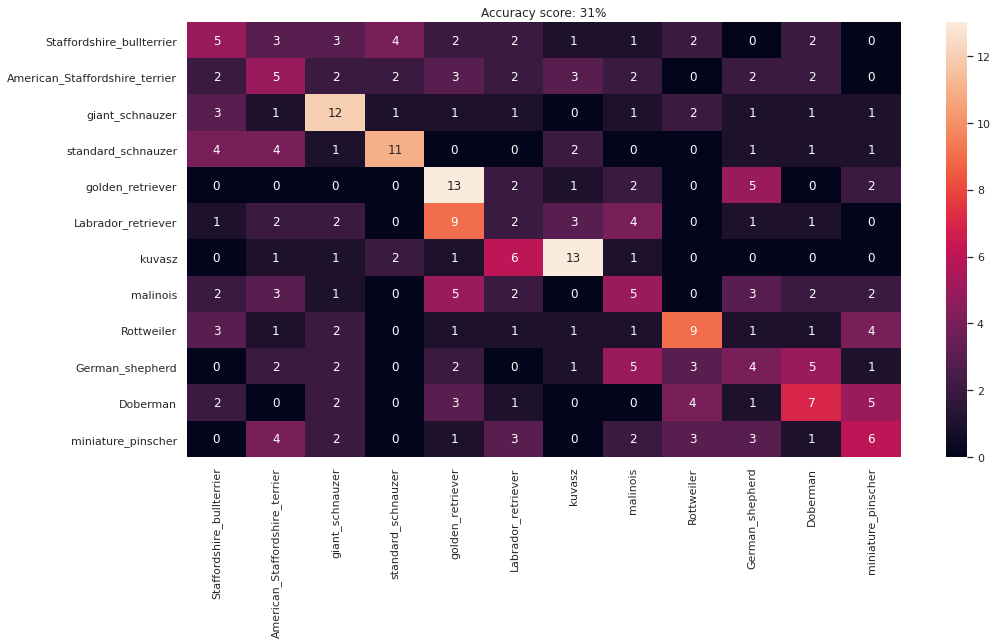

In [20]:
plt.figure(figsize=(16,8))
sns.heatmap(cm, annot=True, xticklabels=labelticks, yticklabels=labelticks, fmt='g');
plt.title(f"Accuracy score: {acc*100.:.0f}%");